### Basic Research Ratio in VAR analysis

TBD

In [1]:
#libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.irf import IRAnalysis
from fredapi import Fred

import warnings
warnings.filterwarnings('ignore')

### Log transformation 
Debated
Pros: Positive variables
Cons: Not sure if necessary

In [2]:
# OECD Basic Research Ratio
RD_BRatio = pd.read_excel('~/Derwent-Data/VAR_Analysis/OECD_RD/OECDBratio1980.xlsx')

In [3]:
# Mean
print(np.mean(RD_BRatio['Bratio']))
print(np.var(RD_BRatio['Bratio']))

0.4191832253116552
0.0015715734926652859


In [4]:
RD_BRatio['log_BRatio'] = np.log(RD_BRatio['Bratio'])

Text(0, 0.5, 'Ratio')

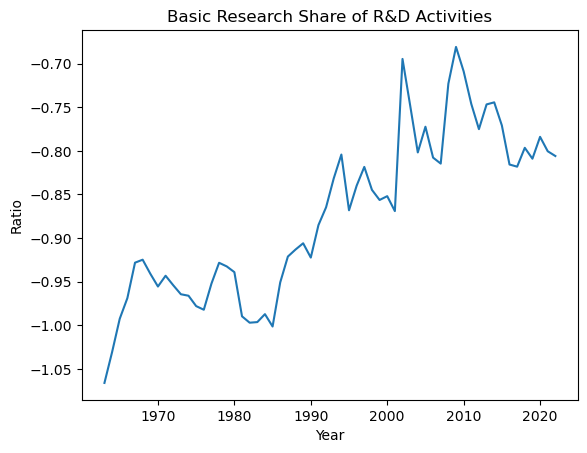

In [5]:
plt.plot(RD_BRatio['Year'], RD_BRatio['log_BRatio'])
plt.title("Basic Research Share of R&D Activities")
plt.xlabel('Year')
plt.ylabel('Ratio')

In [6]:
api = "f778a2073453c711be0c316569a478d2"
fred = Fred(api_key=api)

tfp = fred.get_series('RTFPNAUSA632NRUG') #Annual Total Factor Productivity
lp = fred.get_series('OPHNFB') #Quarterly Labor Productivity
gdp = fred.get_series('GDPC1') #Quarterly Real GDP
#consumption = fred.get_series('PCEC96') Monthly Real Consumption ONLY AVAILABLE AFTER 2007
investment = fred.get_series('GPDIC1') #quarterly real domestic investment
wage = fred.get_series('LES1252881600Q') #quarterly real and seasonally adjusted wage
hours = fred.get_series('B4701C0A222NBEA') #Annual hours worked by full and part time employees

In [40]:
def transform(data):
    data.resample('Y').mean()  #Mean or Sum???
    annual_data = {'year': data.resample('Y').mean().index.year,
                   'value':data.resample('Y').mean()}
    annual_data = pd.DataFrame(annual_data).reset_index(drop=True)
    annual_data['value'] = np.log(annual_data['value'])  #log transformation

    df = pd.DataFrame({'year': range(1963, 2023)})

    df = pd.merge(df, annual_data, on='year', how='left')
    return df #between 1963 to 2022

In [42]:
data = {'year':transform(tfp)['year'],
        'bratio': RD_BRatio['log_BRatio'],
        'tfp': transform(tfp)['value'],
        #'lp':transform(lp)['value'], 
        'gdp': transform(gdp)['value'],
        'investment' : transform(investment)['value'],
        #'wage': transform(wage)['value'],
        'hours': transform(hours)['value']}
data = pd.DataFrame(data)

In [43]:
data = data.dropna()
smdata = data.drop('year', axis=1)

### Productivity and Basic Research Ratio

In [44]:
model = sm.OLS(smdata['tfp'], smdata['bratio']).fit()  #USING PATENT DATA CAN CREATE MORE DATA POINTS ACROSS INDUSTRIES!!! HERE USING R&D CAN ONLY PROVIDE DATA FOR THE AGGREGATE ECONOMY
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    tfp   R-squared (uncentered):                   0.784
Model:                            OLS   Adj. R-squared (uncentered):              0.780
Method:                 Least Squares   F-statistic:                              203.3
Date:                Sun, 17 Nov 2024   Prob (F-statistic):                    2.74e-20
Time:                        17:01:24   Log-Likelihood:                          61.520
No. Observations:                  57   AIC:                                     -121.0
Df Residuals:                      56   BIC:                                     -119.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### ADF test to test stationarity
Decision to use VAR or VECM

In [45]:
def stationarity_test(data):
    adf_result = adfuller(RD_BRatio['Bratio'])
    
    print("ADF Statistic:", adf_result[0])
    print("p-value:", adf_result[1])
    print("Critical Values:", adf_result[4])
    
    # Decision based on p-value
    alpha = 0.05  # significance level
    if adf_result[1] < alpha:
        print("Reject the null hypothesis (H0): The series is stationary.")
    else:
        print("Fail to reject the null hypothesis (H0): The series has a unit root and is non-stationary.")

In [46]:
for col in ['bratio', 'tfp', 'gdp', 'investment', 'hours']:
    print(col)
    stationarity_test(data['bratio'])  #CONFIRMING NON-STATIONARITY

bratio
ADF Statistic: -0.9924334982232366
p-value: 0.7560139949350607
Critical Values: {'1%': -3.5552728880540942, '5%': -2.9157312396694217, '10%': -2.5956695041322315}
Fail to reject the null hypothesis (H0): The series has a unit root and is non-stationary.
tfp
ADF Statistic: -0.9924334982232366
p-value: 0.7560139949350607
Critical Values: {'1%': -3.5552728880540942, '5%': -2.9157312396694217, '10%': -2.5956695041322315}
Fail to reject the null hypothesis (H0): The series has a unit root and is non-stationary.
gdp
ADF Statistic: -0.9924334982232366
p-value: 0.7560139949350607
Critical Values: {'1%': -3.5552728880540942, '5%': -2.9157312396694217, '10%': -2.5956695041322315}
Fail to reject the null hypothesis (H0): The series has a unit root and is non-stationary.
investment
ADF Statistic: -0.9924334982232366
p-value: 0.7560139949350607
Critical Values: {'1%': -3.5552728880540942, '5%': -2.9157312396694217, '10%': -2.5956695041322315}
Fail to reject the null hypothesis (H0): The seri

In [47]:
model = VAR(smdata)
lag_order = model.select_order(maxlags=5)  # 2 lags is ideal
print(lag_order.summary())  
print(f"Optimal lag order based on AIC: {lag_order.selected_orders['aic']}") #Akaike Information Criterion (AIC) and 

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -29.70      -29.52   1.258e-13      -29.63
1      -42.57     -41.44*   3.284e-19      -42.13
2     -43.24*      -41.17  1.726e-19*     -42.44*
3      -43.06      -40.05   2.218e-19      -41.90
4      -43.01      -39.07   2.665e-19      -41.50
5      -42.72      -37.85   4.560e-19      -40.85
-------------------------------------------------
Optimal lag order based on AIC: 2


In [48]:
var_model = model.fit(lag_order.selected_orders['aic'])
var_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 17, Nov, 2024
Time:                     17:01:45
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -41.3335
Nobs:                     55.0000    HQIC:                  -42.5646
Log likelihood:           856.664    FPE:                1.54594e-19
AIC:                     -43.3408    Det(Omega_mle):     6.21279e-20
--------------------------------------------------------------------
Results for equation bratio
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -6.465321         2.511693           -2.574           0.010
L1.bratio             0.475603         0.151750            3.134           0.002
L1.tfp               -0.561084         1.841486           -

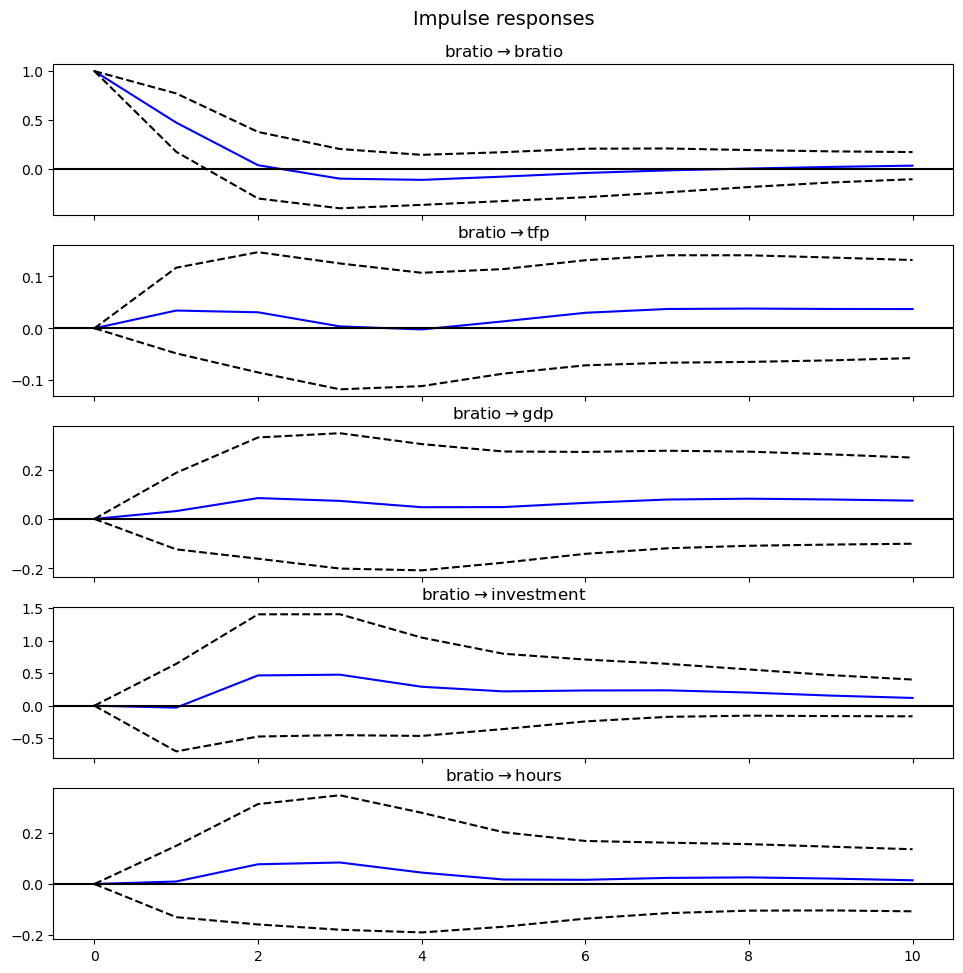

In [50]:
irf = var_model.irf(10)
irf.plot(impulse='bratio', orth=False)
plt.show()

### The previous function does not allow for the customization of shock size. 
Change shock size and sign.

In [51]:
def cus_shock(shock_magnitude):
    # The impulse parameter accepts variable names, so we shock 'y1' and use the default magnitude of 1
    # But we will scale the result manually after it is calculated
    irf_data = irf.orth_irfs[:, smdata.columns.get_loc('bratio'), :]  # IRF data for 'y1'
    
    # Step 4: Scale the IRF data to the desired shock magnitude (e.g., 0.5)
    scaled_irf_data = irf_data * shock_magnitude
    
    # Step 5: Plot the scaled IRF for 'y1'
    plt.figure(figsize=(10, 6))
    plt.plot(scaled_irf_data)
    plt.title(f"Impulse Response to Shock of Magnitude {shock_magnitude}")
    plt.xlabel("Periods")
    plt.ylabel("Response")
    plt.legend(smdata.columns)
    plt.axhline(y=0, color='gray', linestyle=':', linewidth=1)
    plt.show()

### SMALLER SHOCK?

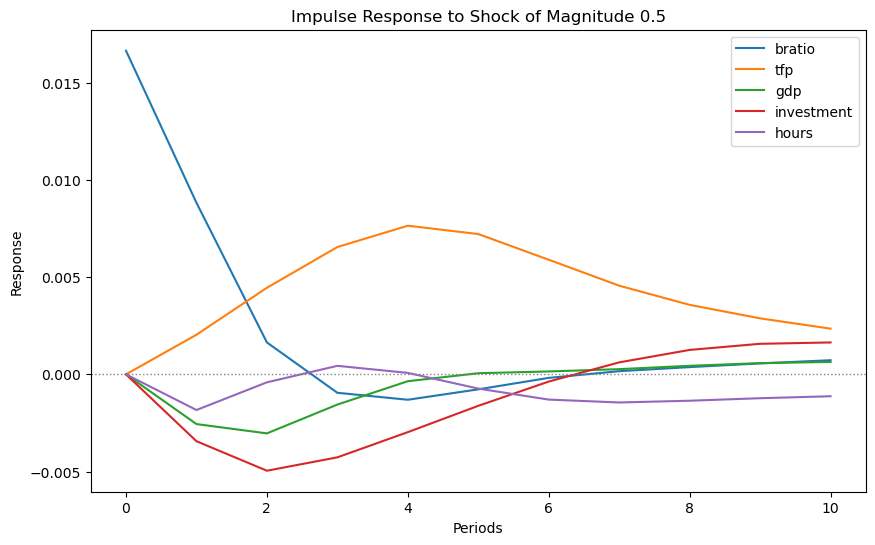

In [52]:
cus_shock(0.5)

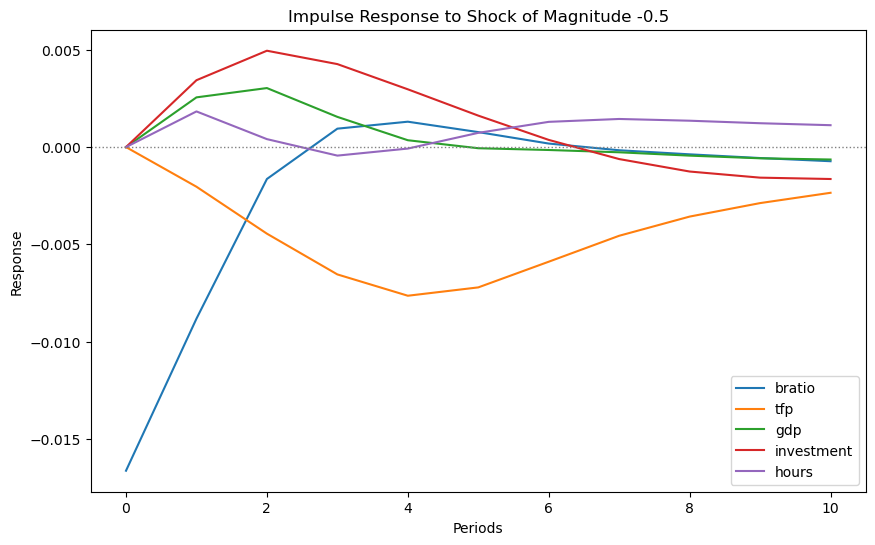

In [53]:
cus_shock(-0.5)

In [60]:
print("Testing if bratio Granger-causes TFP")
grangercausalitytests(smdata[['bratio', 'tfp']], 2, verbose=True)

print("\nTesting if TFP Granger-causes bratio")
grangercausalitytests(smdata[['tfp', 'bratio']], 2, verbose=True)

Testing if bratio Granger-causes TFP

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.8895  , p=0.0069  , df_denom=53, df_num=1
ssr based chi2 test:   chi2=8.3361  , p=0.0039  , df=1
likelihood ratio test: chi2=7.7710  , p=0.0053  , df=1
parameter F test:         F=7.8895  , p=0.0069  , df_denom=53, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.6629  , p=0.0139  , df_denom=50, df_num=2
ssr based chi2 test:   chi2=10.2584 , p=0.0059  , df=2
likelihood ratio test: chi2=9.4062  , p=0.0091  , df=2
parameter F test:         F=4.6629  , p=0.0139  , df_denom=50, df_num=2

Testing if TFP Granger-causes bratio

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3349  , p=0.5652  , df_denom=53, df_num=1
ssr based chi2 test:   chi2=0.3539  , p=0.5519  , df=1
likelihood ratio test: chi2=0.3528  , p=0.5525  , df=1
parameter F test:         F=0.3349  , p=0.5652  , df_denom=53, df_num=1

Granger Causality
number

{1: ({'ssr_ftest': (0.33493255740109984, 0.5652204135785504, 53.0, 1),
   'ssr_chi2test': (0.35389100404644513, 0.5519187484314911, 1),
   'lrtest': (0.3527774888573276, 0.5525450564331718, 1),
   'params_ftest': (0.3349325574010778, 0.5652204135785677, 53.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.880653599242056, 0.42084213747480625, 50.0, 2),
   'ssr_chi2test': (1.9374379183325232, 0.379568970137522, 2),
   'lrtest': (1.9040944691721506, 0.38595008375123585, 2),
   'params_ftest': (0.8806535992420578, 0.42084213747480514, 50.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

In [58]:
print("Testing if bratio Granger-causes output")
grangercausalitytests(smdata[['bratio', 'gdp']], 1, verbose=True)

print("\nTesting if output Granger-causes bratio")
grangercausalitytests(smdata[['gdp', 'bratio']], 1, verbose=True)

Testing if bratio Granger-causes output

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1735  , p=0.0162  , df_denom=53, df_num=1
ssr based chi2 test:   chi2=6.5230  , p=0.0106  , df=1
likelihood ratio test: chi2=6.1702  , p=0.0130  , df=1
parameter F test:         F=6.1735  , p=0.0162  , df_denom=53, df_num=1

Testing if output Granger-causes bratio

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1774  , p=0.6753  , df_denom=53, df_num=1
ssr based chi2 test:   chi2=0.1875  , p=0.6650  , df=1
likelihood ratio test: chi2=0.1871  , p=0.6653  , df=1
parameter F test:         F=0.1774  , p=0.6753  , df_denom=53, df_num=1


{1: ({'ssr_ftest': (0.17741826594850818, 0.6753047276322786, 53.0, 1),
   'ssr_chi2test': (0.18746080930408413, 0.6650384200155026, 1),
   'lrtest': (0.18714774388604383, 0.6653012039146609, 1),
   'params_ftest': (0.1774182659482197, 0.6753047276325286, 53.0, 1.0)},
   array([[0., 1., 0.]])])}

In [57]:
fevd = var_model.fevd(10)
print(fevd.summary())

FEVD for bratio
       bratio       tfp       gdp  investment     hours
0    1.000000  0.000000  0.000000    0.000000  0.000000
1    0.931989  0.010908  0.017184    0.031080  0.008839
2    0.817781  0.054823  0.036053    0.083260  0.008083
3    0.714302  0.133193  0.036226    0.108856  0.007423
4    0.630834  0.219418  0.032060    0.111154  0.006535
5    0.575606  0.282938  0.029210    0.105436  0.006810
6    0.543881  0.319688  0.027631    0.099823  0.008977
7    0.525417  0.339089  0.026795    0.096978  0.011720
8    0.513271  0.349281  0.026439    0.096943  0.014064
9    0.504456  0.354561  0.026425    0.098641  0.015916

FEVD for tfp
       bratio       tfp       gdp  investment     hours
0    0.002344  0.997656  0.000000    0.000000  0.000000
1    0.035892  0.874014  0.046113    0.000003  0.043979
2    0.051836  0.773097  0.091148    0.004574  0.079345
3    0.048606  0.744607  0.101262    0.018467  0.087057
4    0.042826  0.746545  0.091553    0.035951  0.083125
5    0.039601  0.7